[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
93/93 [==============================] - 8s 36ms/step - loss: 3.7781e-05 - val_loss: 0.0059
Epoch 2/50
93/93 [==============================] - 3s 27ms/step - loss: 8.3749e-06 - val_loss: 0.0099
Epoch 3/50
93/93 [==============================] - 3s 27ms/step - loss: 7.3346e-06 - val_loss: 0.0032
Epoch 4/50
93/93 [==============================] - 4s 41ms/step - loss: 5.6362e-06 - val_loss: 0.0046
Epoch 5/50
93/93 [==============================] - 3s 28ms/step - loss: 4.8179e-06 - val_loss: 0.0018
Epoch 6/50
93/93 [==============================] - 2s 27ms/step - loss: 4.7046e-06 - val_loss: 0.0037
Epoch 7/50
93/93 [==============================] - 3s 27ms/step - loss: 4.2417e-06 - val_loss: 0.0050
Epoch 8/50
93/93 [==============================] - 3s 27ms/step - loss: 3.9593e-06 - val_loss: 0.0037
Epoch 9/50
93/93 [==============================] - 4s 42ms/step - loss: 4.1878e-06 - val_loss: 0.0028
Epoch 10/50
93/93 [==============================] - 3s 28ms/step - loss:

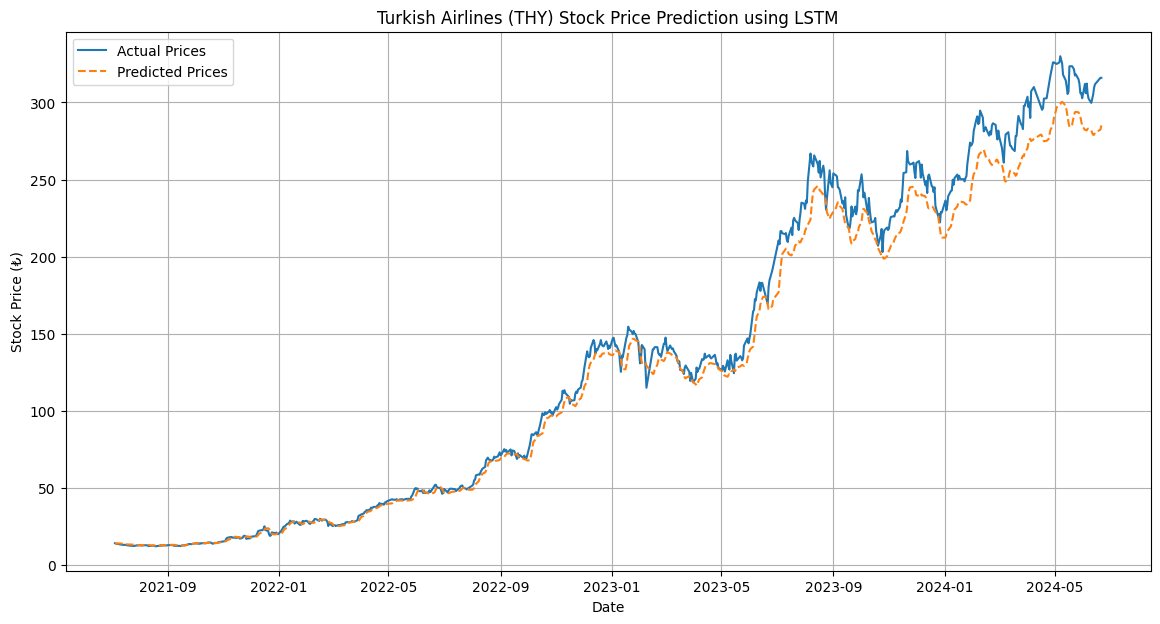

1/1 [==============================] - 0s 25ms/step
Predicted Closing Price for Turkish Airlines (THY) on 2024-07-22: ₺287.51


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# Veriyi yükleyin
ticker = 'THYAO.IS'  # Türk Hava Yolları hisse senedi kodu
start_date = '2010-01-01'
end_date = '2024-07-22'  # Belirli bir tarih
data = yf.download(ticker, start=start_date, end=end_date)

# Kapanış fiyatlarını alın
df = data[['Close']].copy()

# Veriyi normalize edin
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# LSTM için veriyi hazırlayın
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Zaman adımlarını belirleyin
time_steps = 30  # Önceki 30 günü kullanarak tahmin yapacak

# Veriyi hazırlayın
X, y = prepare_data(df_scaled, time_steps)

# Train-test split
split_ratio = 0.8
split = int(split_ratio * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM modeli oluşturun
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Modeli derleyin
model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitin
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=50, batch_size=32, validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test))

# Tahmin yapma
predicted_prices = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
predicted_prices = scaler.inverse_transform(predicted_prices).flatten()

# Gerçek fiyatları alın
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Model performansını değerlendirme
rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
print(f'Root Mean Squared Error: {rmse}')

# Tahmin sonuçlarını görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices')
plt.plot(df.index[-len(predicted_prices):], predicted_prices, label='Predicted Prices', linestyle='--')
plt.title(f'Turkish Airlines (THY) Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price (₺)')
plt.legend()
plt.grid(True)
plt.show()

# Son 30 günlük veriyi alarak belirtilen tarihe kadar tahmin yapma
last_30_days = df_scaled[-time_steps:]  # Son 30 günlük veri
next_day_features = last_30_days.reshape((1, time_steps, 1))  # LSTM modeli için girdi şekline dönüştürme

# Tahmin yapma
predicted_price_scaled = model.predict(next_day_features)
predicted_price = scaler.inverse_transform(predicted_price_scaled)[0, 0]

# Son kullanma tarihi
target_date = pd.to_datetime(end_date)
target_date_str = target_date.strftime('%Y-%m-%d')

# Tahmin sonucunu ve tahmin tarihini gösterme
print(f'Predicted Closing Price for Turkish Airlines (THY) on {target_date_str}: ₺{predicted_price:.2f}')
